<a href="https://colab.research.google.com/github/sanjayd89/Algeria_GreenHouse/blob/main/Time%20Series%20Problem/tomato_crop_time_series_climate_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.0 Importing dependencies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
%matplotlib inline
import pickle
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
tomato = pd.read_csv(r'/content/drive/MyDrive/Data Science Projects/Algeria Greenhouse Project/tomato.csv', encoding="utf-16", delimiter = "\t")
tomato.head()

,时间,日期,室内温度（℃）,室内湿度（%）,室内光照（umol/m2/s）,室内CO2（ppm）,土壤温度（℃）,土壤湿度（%）
0,12:55:15,05/14/2017,33.0,33,2500,445,26.3,18
1,12:56:15,05/14/2017,33.1,35,2500,448,26.3,18
2,12:57:15,05/14/2017,33.0,33,2500,443,26.3,18
3,12:58:15,05/14/2017,33.0,33,2500,443,26.3,18
4,12:59:15,05/14/2017,32.8,33,2500,448,26.3,18


# 2.0 Preprocessing

In [ ]:
tomato.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319130 entries, 0 to 319129
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   时间               319130 non-null  object 
 1   日期               319130 non-null  object 
 2   室内温度（℃）          319130 non-null  float64
 3   室内湿度（%）          319130 non-null  int64  
 4   室内光照（umol/m2/s）  319130 non-null  int64  
 5   室内CO2（ppm）       319130 non-null  int64  
 6   土壤温度（℃）          319130 non-null  float64
 7   土壤湿度（%）          319130 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 19.5+ MB


In [ ]:
tomato.isna().sum()

时间                 0
日期                 0
室内温度（℃）            0
室内湿度（%）            0
室内光照（umol/m2/s）    0
室内CO2（ppm）         0
土壤温度（℃）            0
土壤湿度（%）            0
dtype: int64

## Renaming Columns and combining date & time in one column

In [ ]:
tomato.columns = ['time', 'date', 'indoor_temp', 'indoor_humidity', 'indoor_lighting', 'indoor_CO2', 'soil_temp', 'soil_moisture']
tomato['datetime'] = pd.to_datetime(tomato['date'] + ' ' + tomato['time'])
tomato['datetime'] = pd.to_datetime(tomato['datetime'], format='%d.%m.%Y %H:%M:%S')
tomato = tomato.drop(['date', 'time'], axis = 1)

In [ ]:
tomato.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319130 entries, 0 to 319129
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   indoor_temp      319130 non-null  float64       
 1   indoor_humidity  319130 non-null  int64         
 2   indoor_lighting  319130 non-null  int64         
 3   indoor_CO2       319130 non-null  int64         
 4   soil_temp        319130 non-null  float64       
 5   soil_moisture    319130 non-null  int64         
 6   datetime         319130 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 17.0 MB


## Outlier Detection

In [ ]:
tomato = tomato.set_index('datetime')

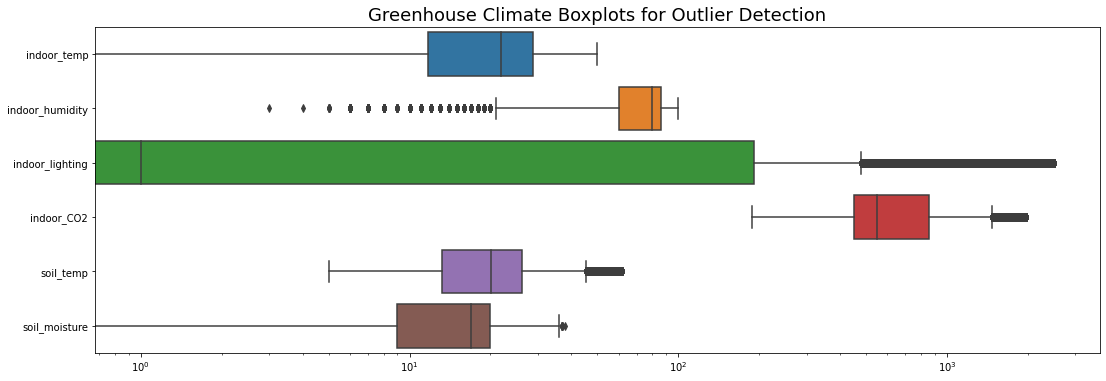

In [ ]:
# Plotting Boxplots of the numerical featutomato

plt.figure(figsize = (18,6))
ax =sns.boxplot(data = tomato, orient="h")
ax.set_title('Greenhouse Climate Boxplots for Outlier Detection', fontsize = 18)
ax.set(xscale="log")
plt.show()

In [ ]:
#removing outliers from remaining columns and replacing with median i.e. 50th percentile
X_columns = tomato.columns

for col in X_columns:  
  q1, q2, q3 = np.percentile(tomato[col], 25), np.percentile(tomato[col], 50), np.percentile(tomato[col], 75)
  IQR = q3 - q1
  upper_limit = q3 + (1.5 * IQR)
  lower_limit = q1 - (1.5 * IQR)
  tomato.loc[tomato[col]< lower_limit, col] = q2
  tomato.loc[tomato[col]> upper_limit, col] = q2  

# 3.0 EDA

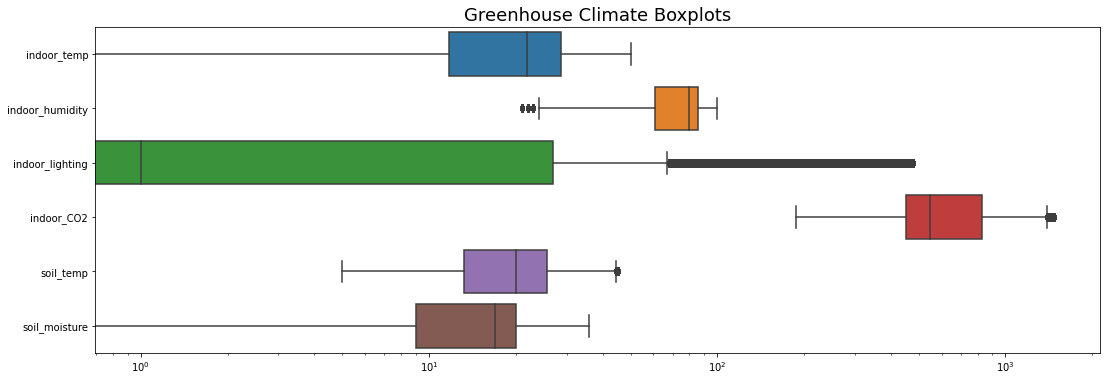

In [ ]:
# Boxplot after Outlier removal

plt.figure(figsize = (18,6))
ax =sns.boxplot(data = tomato, orient="h")
ax.set_title('Greenhouse Climate Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

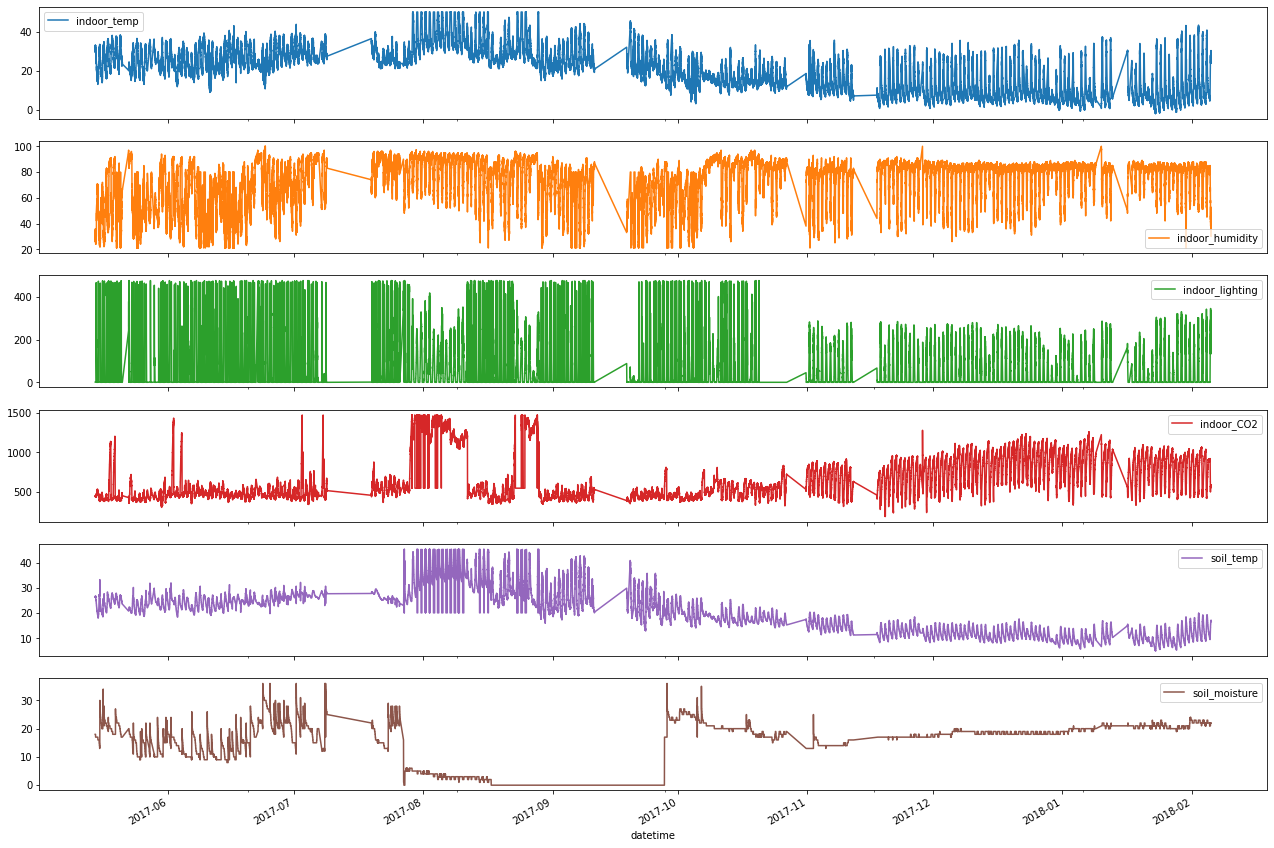

In [ ]:
tomato.plot(figsize = (22, 16), subplots=True, layout=(6,1),);

In [ ]:
# #pickling the combined dataset otherwise we will waste time in doing above curve fitting everytime for new run

# import pickle

# pickle.dump(tomato, open('/content/drive/MyDrive/Data Science Projects/Algeria Greenhouse Project/tomato.pkl', 'wb'))

# 4.0 Model Building

In [3]:
with open('/content/drive/MyDrive/Data Science Projects/Algeria Greenhouse Project/tomato.pkl', 'rb') as file:      
    # Call load method to deserialze
    tomato = pickle.load(file)

tomato.head()

,indoor_temp,indoor_humidity,indoor_lighting,indoor_CO2,soil_temp,soil_moisture
datetime,,,,,,
2017-05-14 12:55:15,33.0,33,1,445,26.3,18
2017-05-14 12:56:15,33.1,35,1,448,26.3,18
2017-05-14 12:57:15,33.0,33,1,443,26.3,18
2017-05-14 12:58:15,33.0,33,1,443,26.3,18
2017-05-14 12:59:15,32.8,33,1,448,26.3,18


### Set seed for reproducibility

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Split data

In [5]:
test_size = int(tomato.shape[0]*0.2)
X_train_raw = tomato.iloc[:-test_size]
X_test_raw = tomato.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)


(255304, 6) (63826, 6)


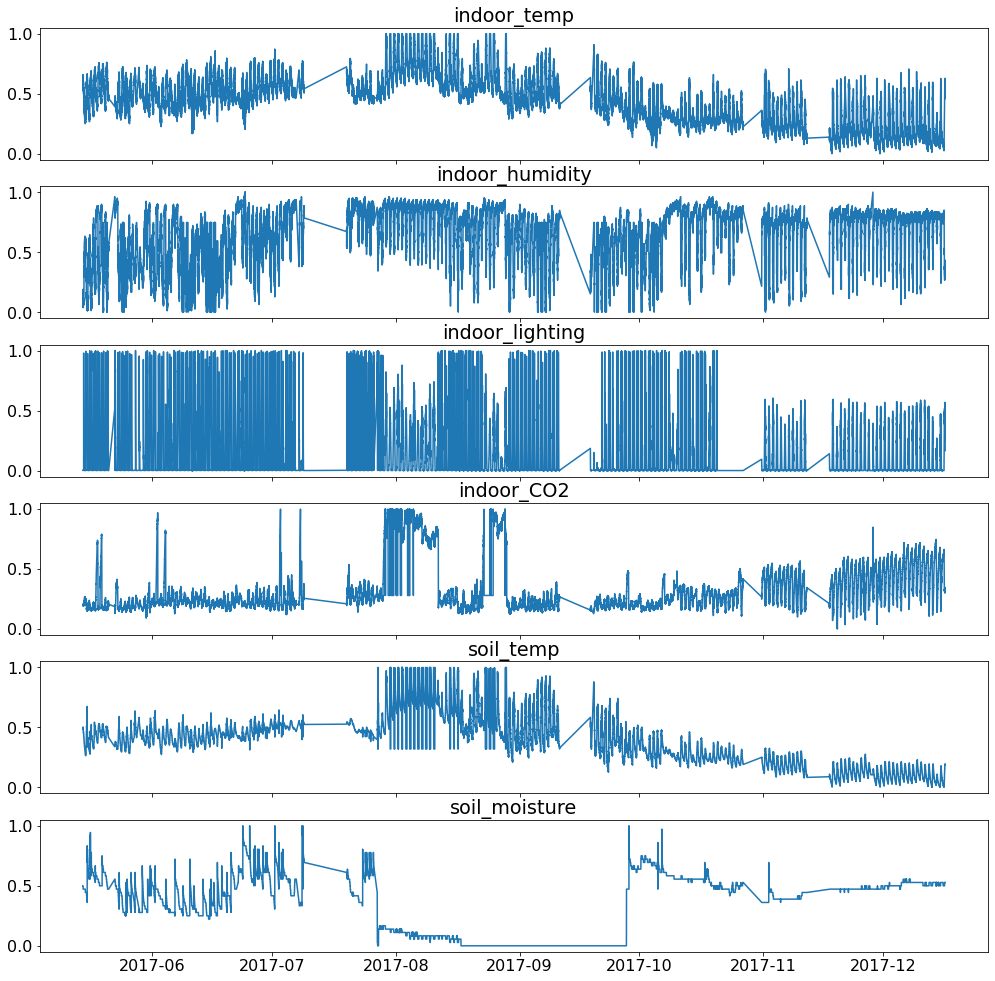

In [6]:
figs, axs = plt.subplots(len(X_train_raw.columns), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(X_train_raw.columns):
    axs[i].plot(X_train_raw[col])
    axs[i].set_title(col)
plt.show()

In [7]:
window = 1440 #no. of minutes in a day
stride = 5

In [8]:
60*1*24

1440

In [9]:
future = tomato[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 1440, 6)

In [10]:
future_index = tomato[-window:].reset_index(drop = False)['datetime']

In [11]:
def build_sequences(df, target_labels, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

### Multivariate Forecasting (Direct)

In [12]:
target_labels = tomato.columns
telescope = 5

In [13]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50975, 1440, 6) (50975, 5, 6)
(12671, 1440, 6) (12671, 5, 6)


In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        #axs[i].set_ylim(0,1)
    plt.show()

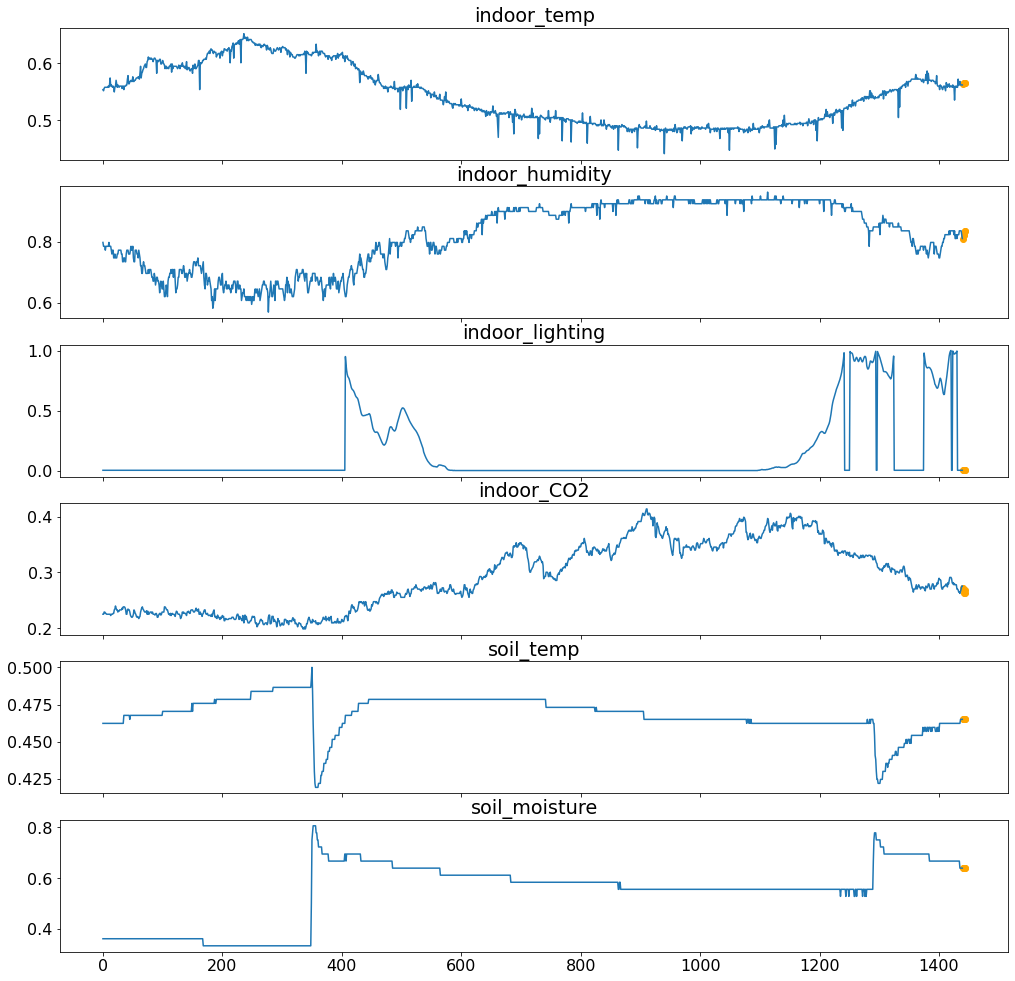

In [ ]:
#Visualize the train data
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 128
epochs = 100

#### Implementation of attention layer

In [ ]:
from keras.layers import Layer
import keras.backend as K

In [ ]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, kernel_initializer=tfk.initializers.GlorotUniform(seed=seed), 
                                            kernel_regularizer=tf.keras.regularizers.l2(1e-3)))(input_layer)
    convlstm = tfkl.Conv1D(128, 5, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, kernel_initializer=tfk.initializers.GlorotUniform(seed=seed), 
                                            kernel_regularizer=tf.keras.regularizers.l2(1e-3)))(convlstm)
    convlstm = tfkl.Conv1D(256, 5, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.4)(convlstm)
 
    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)
 
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
 
    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])
 
    # Return the model
    return model


In [ ]:
print(input_shape)
print(output_shape)

(1440, 6)
(5, 6)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1440, 6)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 1440, 128)        36352     
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 1440, 128)         82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 720, 128)         0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 720, 256)         263168    
 nal)                                                            
                                                             

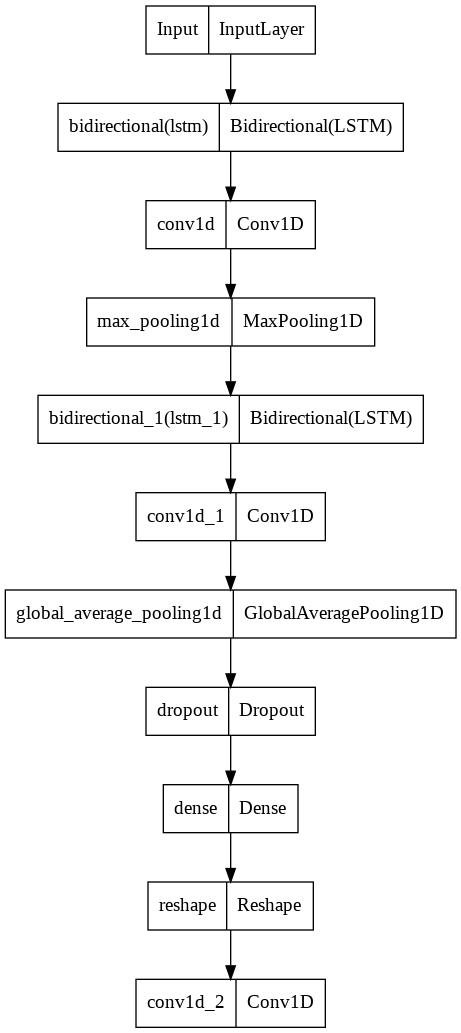

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
#tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.0001, mode='min', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/100
359/359 [==============================] - 128s 311ms/step - loss: 0.0860 - mae: 0.1469 - val_loss: 0.0293 - val_mae: 0.1312 - lr: 0.0010
Epoch 2/100
359/359 [==============================] - 111s 309ms/step - loss: 0.0258 - mae: 0.1118 - val_loss: 0.0231 - val_mae: 0.1212 - lr: 0.0010
Epoch 3/100
359/359 [==============================] - 110s 306ms/step - loss: 0.0232 - mae: 0.1053 - val_loss: 0.0203 - val_mae: 0.1109 - lr: 0.0010
Epoch 4/100
359/359 [==============================] - 111s 311ms/step - loss: 0.0224 - mae: 0.1037 - val_loss: 0.0201 - val_mae: 0.1123 - lr: 0.0010
Epoch 5/100
359/359 [==============================] - 109s 305ms/step - loss: 0.0221 - mae: 0.1030 - val_loss: 0.0195 - val_mae: 0.0985 - lr: 0.0010
Epoch 6/100
359/359 [==============================] - 109s 304ms/step - loss: 0.0218 - mae: 0.1020 - val_loss: 0.0191 - val_mae: 0.1012 - lr: 0.0010
Epoch 7/100
359/359 [==============================] - 109s 304ms/step - loss: 0.0216 - mae: 0.0999 

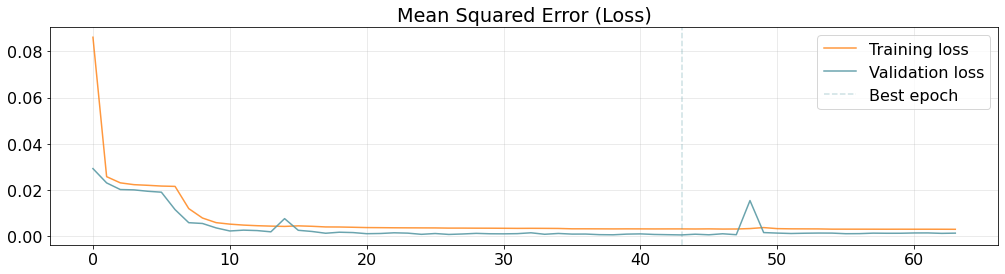

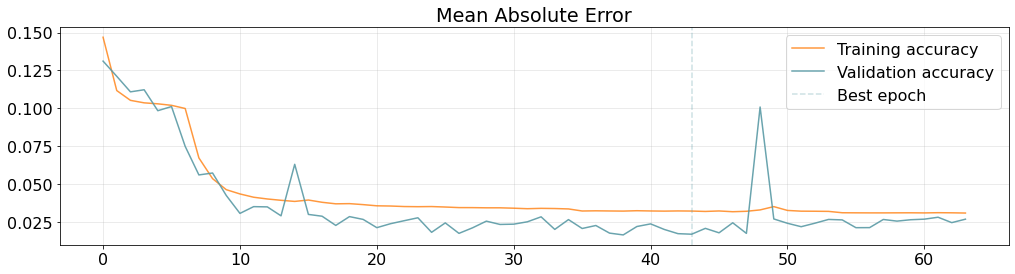

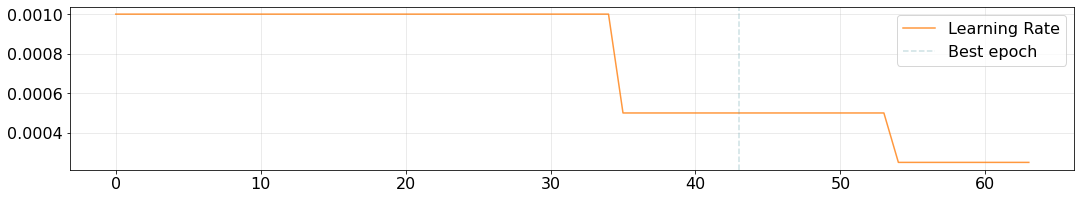

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save(r'/content/drive/MyDrive/Data Science Projects/Algeria Greenhouse Project/model_1D_win_5Stride.h5')


In [14]:
model = tfk.models.load_model('/content/drive/MyDrive/Data Science Projects/Algeria Greenhouse Project/model_1D_win_5Stride.h5')

#### Test evaluation

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

396/396 [==============================] - 353s 885ms/step
(12671, 5, 6)


In [ ]:
mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.001180997>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.023617223>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

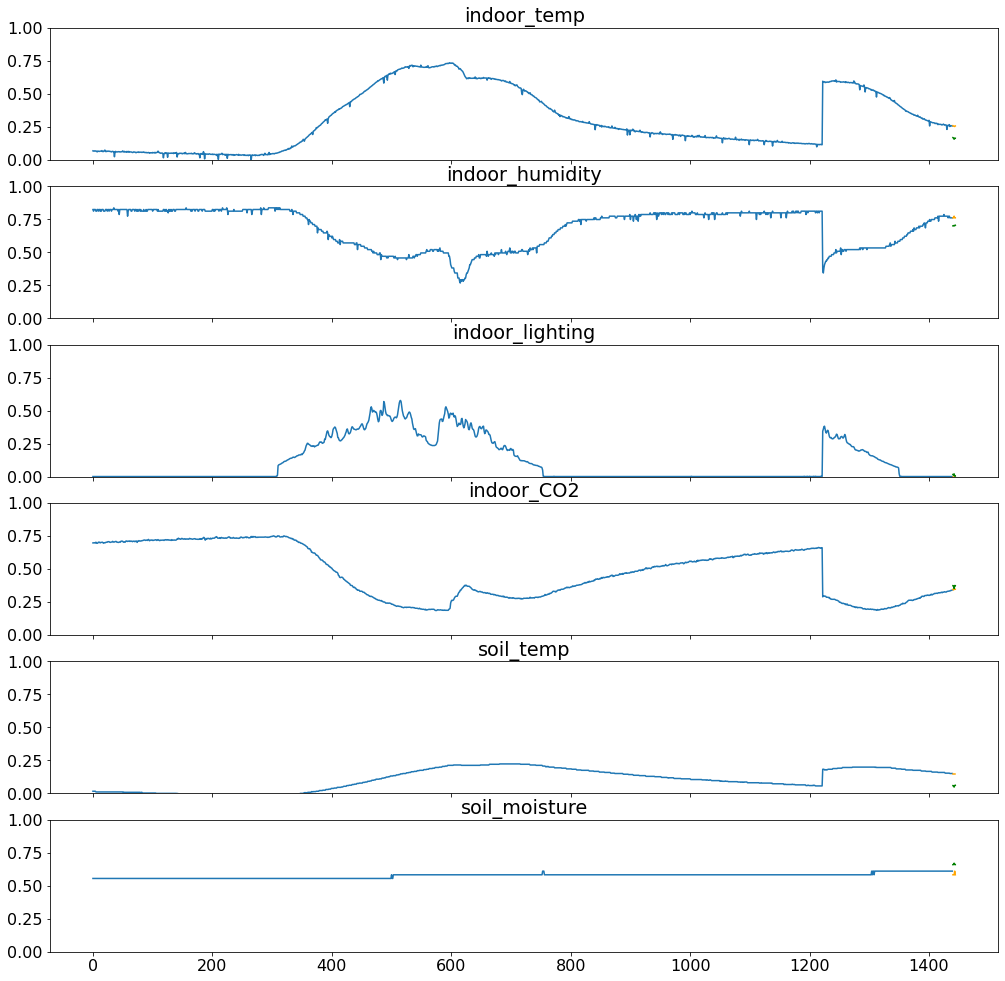

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)#, future_index)

#### Predict the future 

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
future_predictions = model.predict(future)

1/1 [==============================] - 3s 3s/step


In [ ]:
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

In [16]:
df_norm = pd.DataFrame(future_predictions.reshape(future_predictions[0].shape), columns = tomato.columns)

#removing normalizing
future_pred = round((df_norm* (X_max-X_min)) + X_min, 1)

#adding datetime index
last_time_stamp = tomato.reset_index()['datetime'][len(tomato)-1]
timestamplist = [last_time_stamp + timedelta(minutes=i) for i in range(1,telescope+1)]
future_pred['datetime'] = timestamplist
future_pred = future_pred.set_index('datetime')
future_pred

,indoor_temp,indoor_humidity,indoor_lighting,indoor_CO2,soil_temp,soil_moisture
datetime,,,,,,
2018-02-05 15:22:27,25.3,41.5,166.1,539.8,16.8,20.9
2018-02-05 15:23:27,24.9,41.3,167.1,537.2,16.9,20.8
2018-02-05 15:24:27,27.9,43.8,154.2,517.1,15.2,20.9
2018-02-05 15:25:27,24.7,41.3,164.5,535.8,16.9,20.9
2018-02-05 15:26:27,24.6,41.5,165.1,535.8,16.9,20.9


<function matplotlib.pyplot.show(*args, **kw)>

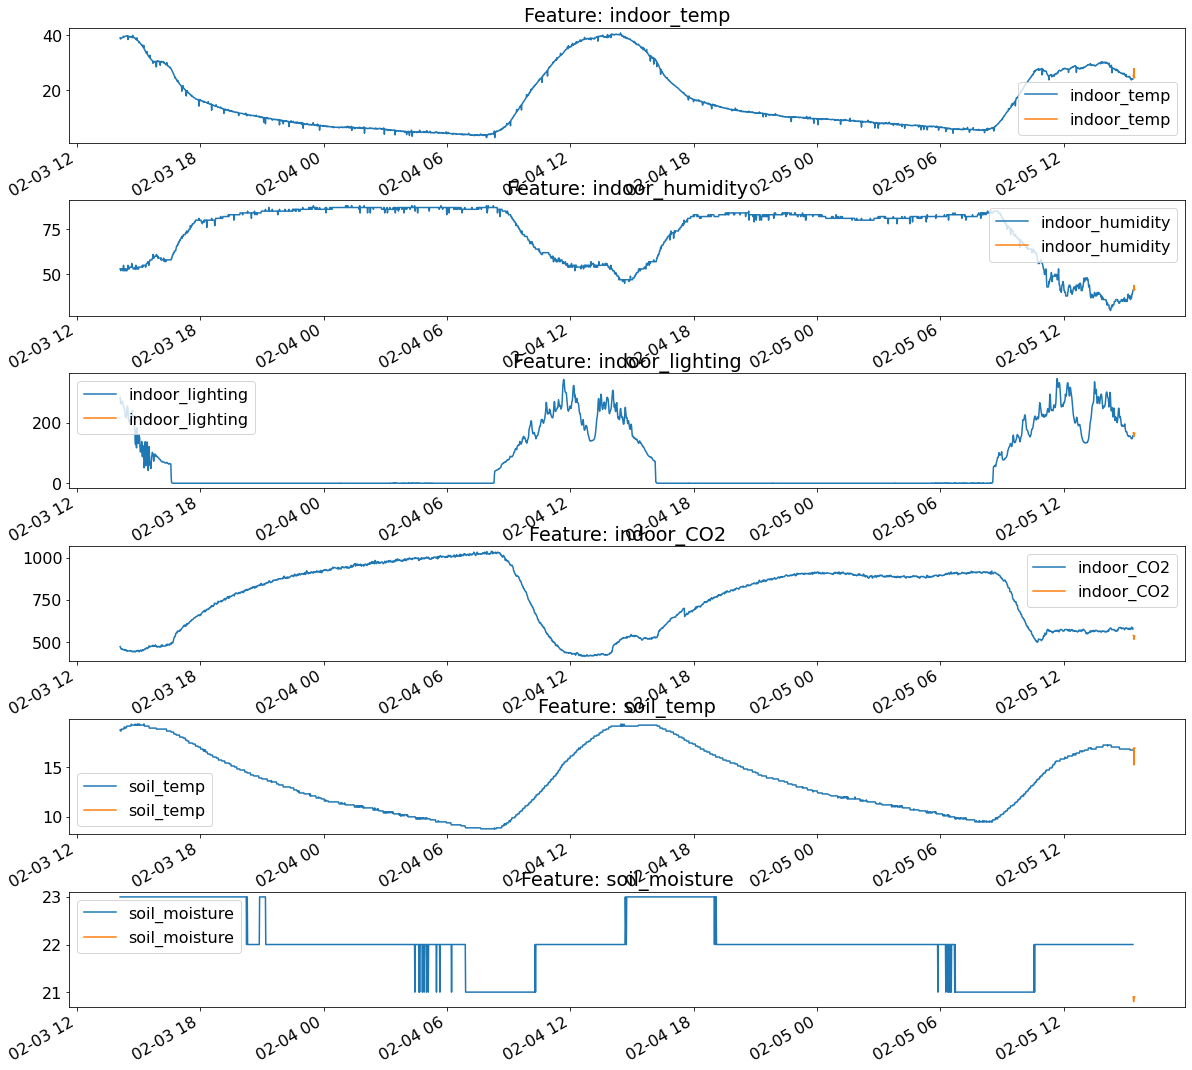

In [17]:
bottom = tomato.tail(1440*2)

plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
#plt.suptitle("Comparison between Setpoints over Time", fontsize=18, y=0.90)

# loop through the length of tickers and keep track of index
for n in range(6):

    col_name = future_pred.columns[n]
    # add a new subplot iteratively
    ax = plt.subplot(6, 1, n + 1)

    # filter df and plot ticker on the new subplot axis
    bottom.iloc[:,n].plot(legend = col_name+' actual') 
    future_pred.iloc[:,n].plot(legend = col_name+' future')     
    plt.legend(loc = 'best')

    # chart formatting
    ax.set_title("Feature: {}".format(col_name))
    ax.set_xlabel("")
plt.show

#### End

- Git upload: 
  - Clone the repo in VS Code
  - Open the Git Bash in the cloned folder
  - git add .
  - git commit -m "pickle file updated"
  - git push origin main


# Ideal values:

- indoor temp: 18 to 27°C (Source: technical sheet)
- indoor humidity 70% (Source: technical sheet)
- indoor lighting - 400-500umole/m2 (Source: [link](https://www.enlitehorti.com/the-light-intensity-required-for-tomatoes.html#:~:text=The%20light%20requirements%20for%20growing%20tomatoes%20indoors%20is%20400%2D500umole,the%20increase%20of%20light%20intensity.))
- CO2 concentration 400 to 1000 ppm (Source: [link](https://www.vegetables.bayer.com/au/en-au/resources/growing-tips/cultivation-insights/managing-light-and-co2-for-tomatoes-in-protected-culture.html))
- Soil temperature - 20 - 25°C (Source: technical sheet)
- Soil moisture - 10-20% (Source: as per the values in dataset, need ideal values)